## Definicion de Generador LXM

NOTA: pongamos una opcion de agregarle una SEED cuando se crea

In [68]:
from numpy import uint64
import numpy as np
from math import exp, factorial
N_BITS = uint64(64)
def rotateLeft(n, d):
    n = uint64(n)
    d = uint64(d)
    return (n << d)|(n >> (N_BITS - d))

def shiftLeft(n, d):
    n = uint64(n)
    d = uint64(d)
    return n << d

def shiftRight(n, d):
    n = uint64(n)
    d = uint64(d)
    return n >> d

class LXM:

    M = uint64(0xd1342543de82ef95)
    a = uint64(13)
    s = uint64(0)
    x0 = uint64(11)
    x1 = uint64(57)
    c = uint64(0xdaba0b6eb09322e3)
    
    def __init__(self, seed=11):
        self.x0 = uint64(seed)
        if self.x0 == self.x1:
            self.x1 += 1
    
    def nextRand(self, n=1):
        if n < 1:
            raise Exception("'n' must be 1 or greater")

        numbers = []
        for i in range(n):
            # Combining operation
            z = self.s + self.x0
            # Mixing function (lea64)
            z = (z ^ (shiftRight(z, 32))) * self.c
            z = (z ^ (shiftRight(z, 32))) * self.c
            z = (z ^ (shiftRight(z, 32)))
            # Update the LCG subgenerator
            self.s = self.M * self.s + self.a
            # Update the XBG subgenerator (xoroshiro128v1_0)
            q0, q1 = self.x0, self.x1
            q1 ^= q0
            q0 = rotateLeft(q0, 24)
            q1 = q0 ^ q1 ^ (shiftLeft(q1, 24))
            q1 = rotateLeft(q1, 37)
            self.x0, self.x1 = q0, q1
            #result
            numbers.append(z / uint64(-1))
            
        return numbers[0] if n==1 else np.array(numbers)

    def generate_normal(self, mean, deviation, n):
        if n < 1:
            raise Exception("'n' must be 1 or greater")
        U1 = self.nextRand(n)
        U2 = self.nextRand(n)
        R = np.sqrt(-2* np.log(U1))
        Theta = 2 * np.pi * U2
        #normal_1 = R * np.cos(Theta)
        normal = R * np.sin(Theta)
        return deviation*normal + mean
    
    def generate_exponential(self, param, n=1):
        if n < 1:
            raise Exception("'n' must be 1 or greater")
        if param < 0:
            raise Exception("the exponential parameter must be greater than 0")
        U = self.nextRand(n)
        return -np.log(1-U)/param
        

### Liberias necesarias

In [2]:
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
gen = LXM()

### Generar numeros con distribucion uniforme en el intervalo 0 - 1

<AxesSubplot:ylabel='Count'>

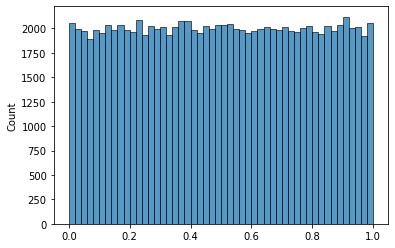

In [3]:
arr = gen.nextRand(100_000)

sns.histplot(bins=50, x=arr)

### Generacion de uniforme en el intervalo a - b

<AxesSubplot:ylabel='Count'>

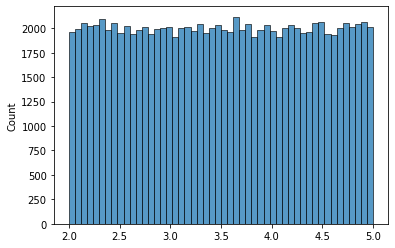

In [4]:
a = 2
b = 5
nums = gen.nextRand(100_000)
nums = nums * (b-a) + a

sns.histplot(bins=50, x=nums)


### Generacion de Normal Estandar con 2 uniformes - Metodo de Box Muller

<AxesSubplot:ylabel='Count'>

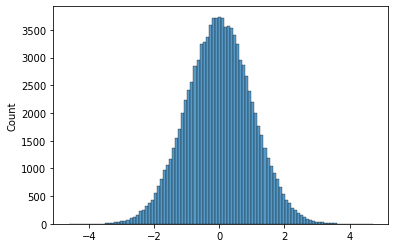

In [5]:
sns.histplot(bins=100, x=gen.generate_normal(0, 1, 100_000))

### Generar la variable aleatoria Normal con esperanza E y desvio D

<AxesSubplot:ylabel='Count'>

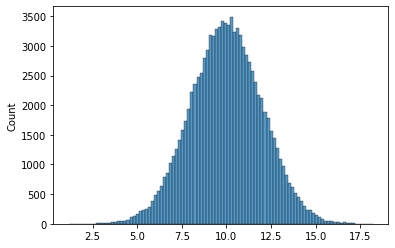

In [6]:

normal2 = gen.generate_normal(10, 2, 100_000)
sns.histplot(bins=100, x=normal2)

In [7]:
# Verificamos
esp = round(normal2.mean(), 2)
desv = round(normal2.std(), 2)
print(f'Normal\nEsperanza = {esp}\nDesvio = {desv}')

Normal
Esperanza = 10.0
Desvio = 2.0


## Test de Kolmogorov Smirnov
* H0: La muestra sigue una distribucion uniforme
* H1: La muestra no sigue una distribucio uniforme

Vemos si podemos rechazar (o no) H0.

In [8]:
from scipy import stats
for n in [10, 10_000, 100_000]:
    data = gen.nextRand(n)
    kstest_test = stats.kstest(data, 'uniform')
    if kstest_test.pvalue > 0.05:
        print('Datos uniformes (No se puede rechazar H0)')
    else:
        print('Datos no uniformes (Se rechaza H0)')

Datos uniformes (No se puede rechazar H0)
Datos uniformes (No se puede rechazar H0)
Datos uniformes (No se puede rechazar H0)


## Test de normalidad 

* H0: La muestra sigue una distribucion normal
* H1: La muestra no sigue una distribucio normal

Vemos si podemos rechazar (o no) H0.

In [9]:
# Anderson-Darling Test
from scipy.stats import anderson

for n in [10, 10_000]:
    print(f"\nTest n = {n}")
    data = gen.generate_normal(2, 10, n)
    #Ejecutamos el test de normalidad (por defecto compara contra Normal)
    resultado = anderson(data)
    print('Estadístico: %.3f' % resultado.statistic)
    for i in range(len(resultado.critical_values)):
        nivel_significancia, umbral = resultado.significance_level[i]/100, resultado.critical_values[i]
        if resultado.statistic < resultado.critical_values[i]:
            print('%.3f: %.3f, Datos normales (No se puede rechazar H0)' % (nivel_significancia, umbral))
        else:
            print('%.3f: %.3f, Datos No normales (Se rechaza H0)' % (nivel_significancia, umbral))


Test n = 10
Estadístico: 0.585
0.150: 0.501, Datos No normales (Se rechaza H0)
0.100: 0.570, Datos No normales (Se rechaza H0)
0.050: 0.684, Datos normales (No se puede rechazar H0)
0.025: 0.798, Datos normales (No se puede rechazar H0)
0.010: 0.950, Datos normales (No se puede rechazar H0)

Test n = 10000
Estadístico: 0.274
0.150: 0.576, Datos normales (No se puede rechazar H0)
0.100: 0.656, Datos normales (No se puede rechazar H0)
0.050: 0.787, Datos normales (No se puede rechazar H0)
0.025: 0.918, Datos normales (No se puede rechazar H0)
0.010: 1.092, Datos normales (No se puede rechazar H0)


### Test de Saphiro para distribucion normal

In [10]:
from scipy import stats
for n in [10, 10_000, 100_000]:
    data = gen.generate_normal(2, 10, n)
    shapiro_test = stats.shapiro(data)
    if shapiro_test.pvalue > 0.05:
        print('Datos normales (No se puede rechazar H0)')
    else:
        print('Datos no normales (Se rechaza H0)')

Datos normales (No se puede rechazar H0)
Datos normales (No se puede rechazar H0)
Datos normales (No se puede rechazar H0)


### Ej 4: iniciamos cargando el archivo de arribos y graficando la distribucion

In [11]:
tiempos_entre_arribos = np.loadtxt('tiempos_entre_arribos.txt')
tiempos_entre_arribos.shape

(10000,)

Los tiempos entre arribos deberian estar distribuidos como una exponencial

<AxesSubplot:ylabel='Count'>

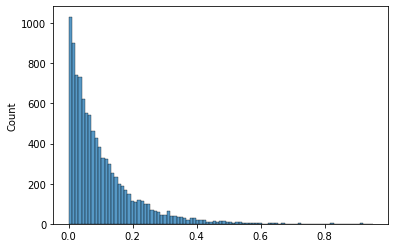

In [12]:
sns.histplot(tiempos_entre_arribos)

Si hacemos la suma acumulativa, obtenemos todos los eventos de un proceso de Poisson

<AxesSubplot:>

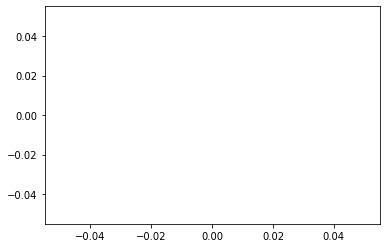

In [13]:
eventos_proceso = tiempos_entre_arribos.cumsum()
sns.scatterplot(eventos_proceso)

Estimamos la tasa de arribos lambda como el parametro de las exponenciales (tiempo entre arribos). Calculamos la media de las exponenciales y lambda será 1/media

In [14]:
lam = round(1/tiempos_entre_arribos.mean(), 2)
print(f'El parametro lambda es {lam} arribos de vehiculos por hora')

El parametro lambda es 9.89 arribos de vehiculos por hora


### Realizamos un test sobre los tiempos entre arribos para confirmar que provienen de una distribucion exponencial y por lo tanto tratamos con un proceso de Poisson

Realizamos un Test de Kolmogorov Smirnov
* H0: La muestra sigue una distribucion exponencial
* H1: La muestra no sigue una distribucio exponencial

Vemos si podemos rechazar (o no) H0.

In [15]:
from scipy import stats
for i in range(5):
    # creo muestra exponencial con mismos parametros que nuestros datos
    exp = stats.expon.rvs(scale=1/lam, size=len(tiempos_entre_arribos))
    kstest_test = stats.kstest(tiempos_entre_arribos, exp)
    if kstest_test.pvalue > 0.05:
        print('Datos exponenciales (No se puede rechazar H0)')
    else:
        print('Datos no exponenciales (Se rechaza H0)')

Datos exponenciales (No se puede rechazar H0)
Datos exponenciales (No se puede rechazar H0)
Datos exponenciales (No se puede rechazar H0)
Datos exponenciales (No se puede rechazar H0)
Datos exponenciales (No se puede rechazar H0)


## Ejercicio 4 b

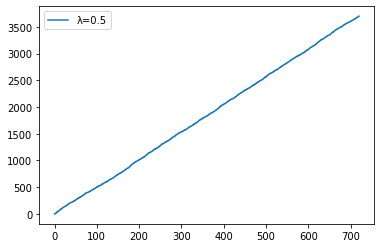

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import random as rn

# función de distribución de probabilidades conocida fy(x)
def fy(x):
    if x>=0 and x<=1:
        return 1
    return 0

# función de distribución de probabilidades que queremos lograr (exponencial (0.5)) fx(x)
def fx(x, lamb):
    return lamb * exp(-lamb * x)


def aceptar_o_rechazar_exp(lamb, x):
    # Calculamos c para método de aceptacion rechazo
    # El maximo de la exponencial esta en t= 0 y vale lambda
    c = lamb
    
    while True:
        
        # Numero generado por variable aleatoria con distribucion u(0,1)
        ui = rn.random()
        
        # calculamos cociente:
        a = fx(x, lamb) / (c * fy(x)) 
        
        return ui < a

    
def run_poisson_process(lamb, tmax):
    generador = LXM()
    
    # Guaramos el tiempo de los arribos que van llegando
    t=[]
    
    # Partinmos desde t0=0
    arribo=0
    
    valores_gen = generador.nextRand(100_000)
    
    i=-1
    while (arribo <= tmax):
        i+=1
        z = valores_gen[i]
        aceptacion = aceptar_o_rechazar_exp(lamb, z)
        if not aceptacion:
            continue
        
        # Te paras en el anterior y le sumas el nuevo tiempo
        arribo=arribo+z
        # Lo agregas a la lista
        t.append(arribo)
       
    return t

# Parametro de la exponencial (0.5 HORAS)
lamb = 5

# tiempo maximo
tmax = 30 * 24 #(HORAS)

# Corro el proceso
t = run_poisson_process(lamb, tmax)

# En este momento tu t0=0 y tn= tiempo del maximo arribo
# Estan todos guardados en la lista
    
# Grafico 
# En el eje horizontal tenemos el tiempo
# En el eje vertical tenemos la cantidad de arribos par aun instante t
plt.step(t,range(len(t)),where= 'post' ,label='λ=0.5')
plt.legend()
plt.show()

## Ejercicio 4 c

In [57]:
# 1. Probabilidad que el primer vehículo arribe antes de los 10 minutos.

In [58]:
# TEÓRICO:
# sn = tiempo del arribo n -> s1 = tiempo del arribo 1
# si lambda = 0.5 entonce sn tiene distribucion gama(1, 0.5)
# Ahora bien si tn es una variable aleatoria que modela el tiempo que transcurre entre el arribo n 
# y el n-1 y n=1 entonces t1 es tambien el tiempo del arribo 1
# Luego t1 tiene distribución exponencial(0.5)
# Se A = el primer vehiculo arriba antes de los 10 minutos (10/60 horas) entonces
# queremos P(A < 10) = p ( t1 < 10) = 1 - e**- 0.5 10/60 = 0.079956 

In [69]:
# SIMULACIÓN

# Parametro de la exponencial (0.5 HORAS)
lamb = 0.5

# tiempo maximo
tmax = 30 * 24 #(HORAS)

# cantindad de intentos
n = 10

# Calculo los casos favorables
favorables = 0
#corro 1000 veces el experimento
for i in range (0,n):
    t = run_poisson_process(lamb, tmax)
    
    t_primer_arribo = t[0]
    
    if t_primer_arribo < 10/60:
        favorables += 1

# P = Favoriables / totales
P = favorables / n

print(P)

0.0


In [ ]:
# 2. Probabilidad que el undécimo vehículo arribe después de los 60 minutos.

In [ ]:
# TEORICO
# S11 = tiempo del undecimo arribo, s11 tiene distribucion gama de parametros (11, 0.5)
# Queremos la probabilidad de que S11 > 1 (60 min)
# Sea N(t) una variable aleatoria que modela la cantidad de arribos entre 0 y t entonces N(1) modela la cantidad de arribos en 1h
# N(t) tiene distribucion poisson de parametro(lambda t) entonces N(1) tiene distribucion poisson (0.5 1)
# Si el undecimo vehiculo arriba despues de la primera hora entonces en 1 hora deben arriba 10 o menos entonces:
# Sea B = En la primera hora arriban 10 o menos vehiculo entonces P(S11) = P(B) = P(N(1) < 10) ) = 
# SUM i=0,10 (mu**x e-mu / x!) = 0.9999

# Apendice:
# ((0.5^0)*e^-0.5)/0!+((0.5^1)*e^-0.5)/1!+((0.5^2)*e^-0.5)/2!+((0.5^3)*e^-0.5)/3!+((0.5^4)*e^-0.5)/4!+((0.5^5)*e^-0.5)/5!+((0.5^6)*e^-0.5)/6!+((0.5^7)*e^-0.5)/7!+((0.5^8)*e^-0.5)/8!+((0.5^9)*e^-0.5)/9!+((0.5^10)*e^-0.5)/10!


In [71]:
# SIMULACIÓN

# cantindad de intentos
n = 10
# Parametro de la exponencial (0.5 HORAS)
lamb = 0.5

# tiempo maximo
tmax = 30 * 24 #(HORAS)

# Calculo los casos favorables
favorables = 0

#corro 1000 veces el experimento
for i in range (0,n):
    t = run_poisson_process(lamb, tmax)
    
    t_undecimo_arribo = t[11]
    
    if t_undecimo_arribo > 1:
        favorables += 1

# P = Favoriables / totales
P = favorables / n

print(P)

1.0


In [ ]:
# 3. Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.

In [ ]:
from math import exp, factorial

# TEORICO

P = 0

mu = 0.5 * 72

def p(x, mu):
    return ((mu**x) * exp(-mu) / factorial(x))
  

for x in range(0,750):
    P += p(x, mu)


In [ ]:
factorial(750)

In [ ]:
# SIMULACIÓN

# cantindad de intentos
n = 1000

# Parametro de la exponencial 4 vehiculos por hora aprox
lamb = 1/0.5

# tiempo maximo -> Por propiedad de perdida de memoria de la exponencial
tmax = 72 #(HORAS)

# Calculo los casos favorables
favorables = 0

#corro 1000 veces el experimento
for i in range (0,n):
    t = run_poisson_process(lamb, tmax)
    
    cant_arribos = len(t)
    
    if cant_arribos >= 750:
        favorables += 1   

# P = Favoriables / totales
P = favorables / n

print(P)